# 範例重點
了解如何 reset Tensorflow Graph <br />
學習如何以迴圈方式訓練不同超參數的模型<br />
學習如何以迴圈方式繪圖<br />

In [1]:
import os 
import keras

#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
!nvidia-smi

Mon Jul 15 13:03:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    18W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def preproc_x(x, flatten = True):
  x = x / 255.0
  if flatten:
    x = x.reshape((len(x),-1))
  return x

def preproc_y(y, num_classes = 10):
  if y.shape[-1] == 1 :
      return keras.utils.to_categorical(y, num_classes)
  return y

In [0]:
train_x = preproc_x(train_x)
test_x = preproc_x(test_x)

train_y = preproc_y(train_y)
test_y = preproc_y(test_y)

In [0]:
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
  
  input_layer = keras.layers.Input(input_shape, name = "main_input")
  
  for i, n_units in enumerate(num_neurons):
    if i == 0:
      x = keras.layers.Dense(num_neurons[i], activation = 'relu', name = 'hidden_layer' + str(i+1))(input_layer)
    else:
      x = keras.layers.Dense(num_neurons[i], activation = 'relu', name = 'hidden_layer' + str(i+1))(x)
  
  output_layer = keras.layers.Dense(units = output_units, activation = 'softmax', name = "main_output")(x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model

In [0]:
lr_rate = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
epochs = 50
batch_size = 256
momentum = 0.95

In [9]:
results = {}

for lr in lr_rate:
  #clean the old graph
  keras.backend.clear_session()
  
  print(f"Experiment with lr : {lr}")
  model = build_mlp(train_x.shape[1:])
  model.summary()
  
  optimizer = keras.optimizers.SGD(lr = lr, nesterov = True, momentum = momentum)
  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
  
  history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, validation_data = [test_x,test_y], shuffle = True)
  
  exp_name_tag = f"exp-lr-{str(lr)}"
  results[exp_name_tag] = {'train_loss' : history.history['loss'],
                          'valid_loss' : history.history['val_loss'],
                          'train_acc'  : history.history['acc'],
                          'valid_acc'  : history.history['val_acc'] }
  

W0715 13:03:54.496449 140527751489408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0715 13:03:54.498058 140527751489408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0715 13:03:54.541472 140527751489408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 13:03:54.542489 140527751489408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W071

Experiment with lr : 0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] -

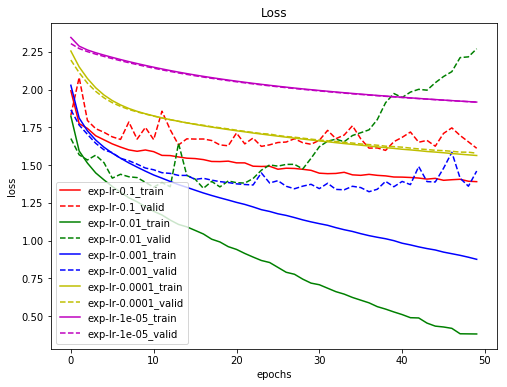

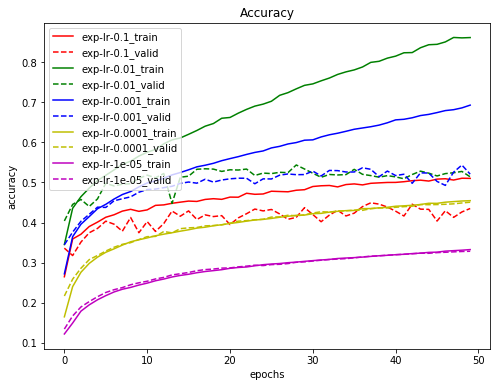

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

colors = ['r', 'g', 'b', 'y', 'm', 'k']

plt.figure(figsize = (8,6))

for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_loss'], '-', label = cond + "_train", color = colors[i])
  plt.plot(results[cond]['valid_loss'],'--', label = cond + "_valid", color = colors[i])

plt.xlabel("epochs")
plt.ylabel('loss')
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_acc'], '-', label = cond + "_train", color = colors[i])
  plt.plot(results[cond]['valid_acc'], '--',label = cond + "_valid", color = colors[i])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

# Homework
請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [0]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

In [0]:
train_x = preproc_x(train_x, flatten = False)
train_y = preproc_y(train_y)
test_x = preproc_x(test_x, flatten = False)
test_y = preproc_y(test_y)

In [0]:
def build_mlp2(input_shape, output_units = 10):
  
  input_layer = keras.layers.Input(input_shape)
  
  x = keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(input_layer)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size = (2,2))(x)
  x = keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPooling2D(pool_size = (2,2))(x)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units = 512, activation = 'relu')(x)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Dense(units = 256, activation = 'relu')(x)
  x = keras.layers.Dropout(0.25)(x)
  x = keras.layers.Dense(units = 128, activation = 'relu')(x)
  
  output_layer = keras.layers.Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model
  

In [0]:
#Hyper-parameters setting

lr = 0.001
momentums = [0.95,0.9,0.8,0.99]
epochs = 30
batch_size = 128

In [30]:
results = {}
for i, momentum in enumerate(momentums):
   
  keras.backend.clear_session()
  print(f"Experiment with momentum : {momentum}")
  
  model = build_mlp2(train_x.shape[1:])
  optimizer = keras.optimizers.SGD(lr = lr, nesterov = False, momentum =  momentum)
  model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
  
  history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = [test_x, test_y])
  
  exp_name_tag = f"exp_momentum_{str(momentum)}"
  results[exp_name_tag] = {'train_loss' : history.history['loss'],
                          'valid_loss' : history.history['val_loss'],
                          'train_acc'  : history.history['acc'],
                          'valid_acc'  : history.history['val_acc'] }
 

Experiment with momentum : {momentum}
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 14s 281us/step - loss: 1.8721 - acc: 0.3228 - val_loss: 1.9182 - val_acc: 0.3237
Epoch 2/30
50000/50000 [==============================] - 10s 208us/step - loss: 1.4649 - acc: 0.4601 - val_loss: 1.4061 - val_acc: 0.4857
Epoch 3/30
50000/50000 [==============================] - 10s 209us/step - loss: 1.3041 - acc: 0.5223 - val_loss: 1.2154 - val_acc: 0.5651
Epoch 4/30
50000/50000 [==============================] - 10s 207us/step - loss: 1.1904 - acc: 0.5677 - val_loss: 1.1345 - val_acc: 0.5810
Epoch 5/30
50000/50000 [==============================] - 10s 206us/step - loss: 1.0949 - acc: 0.6020 - val_loss: 0.9901 - val_acc: 0.6418
Epoch 6/30
50000/50000 [==============================] - 10s 206us/step - loss: 1.0111 - acc: 0.6375 - val_loss: 0.9955 - val_acc: 0.6451
Epoch 7/30
50000/50000 [==============================] - 10s 205us/step - los

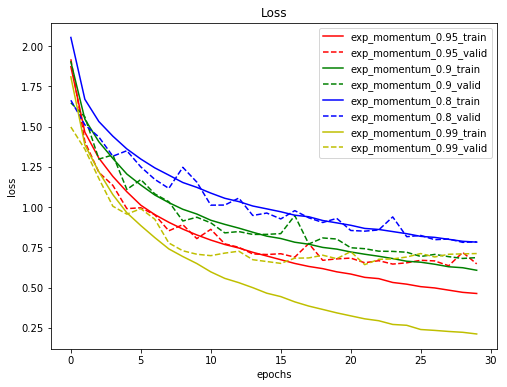

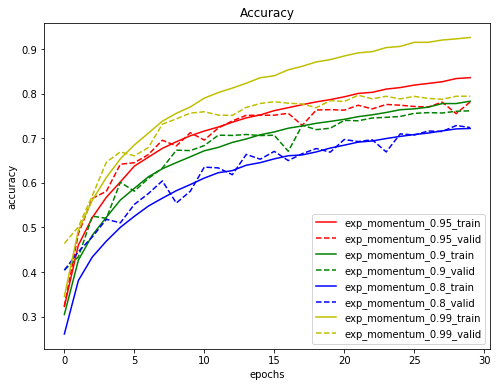

In [31]:
colors = ['r', 'g', 'b', 'y', 'm', 'k']

plt.figure(figsize = (8,6))

for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_loss'], '-', label = cond + "_train", color = colors[i])
  plt.plot(results[cond]['valid_loss'],'--', label = cond + "_valid", color = colors[i])

plt.xlabel("epochs")
plt.ylabel('loss')
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_acc'], '-', label = cond + "_train", color = colors[i])
  plt.plot(results[cond]['valid_acc'], '--',label = cond + "_valid", color = colors[i])

plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

In [32]:
final_model = build_mlp2(train_x.shape[1:])
final_model.summary()

optimizer = keras.optimizers.SGD(lr = lr, nesterov = True, momentum = 0.9)
final_model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])
history = final_model.fit(train_x, train_y, epochs = 50, batch_size = batch_size, validation_data = [test_x, test_y], shuffle = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        18464     
__________

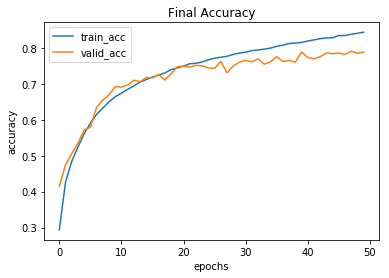

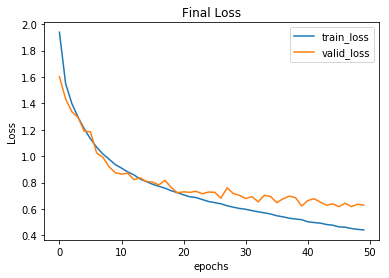

In [34]:
plt.plot(history.history['acc'], label = 'train_acc')
plt.plot(history.history['val_acc'], label = 'valid_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Final Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'valid_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Final Loss')
plt.legend()
plt.show()